In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
file_path = "filtered_malicious_phish_frfrfr.xls"

In [3]:
data = pd.read_csv(file_path)
print(data)

                                                      url      type
0                                        br-icloud.com.br  phishing
1                     mp3raid.com/music/krizz_kaliko.html    benign
2                         bopsecrets.org/rexroth/cr/1.htm    benign
3       http://buzzfil.net/m/show-art/ils-etaient-loin...    benign
4           espn.go.com/nba/player/_/id/3457/brandon-rush    benign
...                                                   ...       ...
522209            xbox360.ign.com/objects/850/850402.html  phishing
522210       games.teamxbox.com/xbox-360/1860/Dead-Space/  phishing
522211         www.gamespot.com/xbox360/action/deadspace/  phishing
522212      en.wikipedia.org/wiki/Dead_Space_(video_game)  phishing
522213          www.angelfire.com/goth/devilmaycrytonite/  phishing

[522214 rows x 2 columns]


In [4]:
phishing_data = data[data['type'] == 'phishing']
benign_data = data[data['type'] == 'benign']

In [5]:
phishing_count = phishing_data.shape[0]
benign_count = benign_data.shape[0]

In [6]:
min_phishing_count = int(benign_count * 0.7)
max_phishing_count = int(benign_count * 1.3)

if phishing_count < min_phishing_count:
    additional_phishing_count = min_phishing_count - phishing_count
elif phishing_count > max_phishing_count:
    additional_phishing_count = 0
else:
    additional_phishing_count = 0

if additional_phishing_count > 0:
    replicated_phishing_data = phishing_data.sample(n=additional_phishing_count, replace=True, random_state=42)
    augmented_data = pd.concat([data, replicated_phishing_data])
else:
    augmented_data = data.copy()

# Shuffle the dataset
augmented_data = augmented_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
print(augmented_data['type'].value_counts())

type
benign      428103
phishing    299672
Name: count, dtype: int64


In [8]:
print(augmented_data.head())

                                                 url      type
0                        www.exontrol.com/extree.jsp  phishing
1  hiplyrics.com/t/the-bilz-and-kashif-single-lyr...    benign
2        www.pennine.demon.co.uk/family/armbasic.htm  phishing
3  https://hoysalacreations.com/wp-content/plugin...  phishing
4  groups.csail.mit.edu/mac/projects/scheme/rrrs-...  phishing


#EDA

In [9]:
print(augmented_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727775 entries, 0 to 727774
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     727775 non-null  object
 1   type    727775 non-null  object
dtypes: object(2)
memory usage: 11.1+ MB
None


In [10]:
print(augmented_data.describe())

                                           url    type
count                                   727775  727775
unique                                  522166       2
top     http://www.jjscdc.cn/adfile/login.html  benign
freq                                        15  428103


In [11]:
print(augmented_data.isnull().sum())

url     0
type    0
dtype: int64


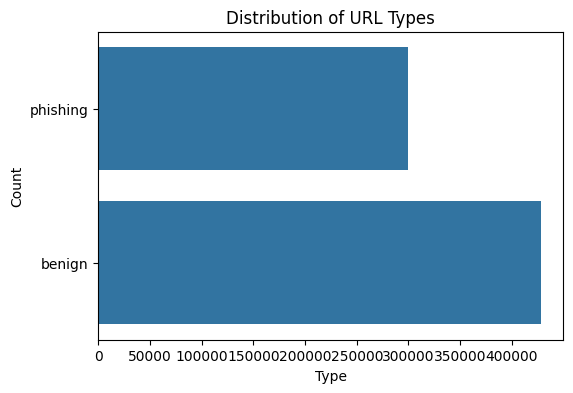

type
benign      428103
phishing    299672
Name: count, dtype: int64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(augmented_data['type'])
plt.title('Distribution of URL Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

print(augmented_data['type'].value_counts())

In [13]:
#Just want to do an analysis on the URL length as well
augmented_data['url_length'] = augmented_data['url'].apply(len)

In [14]:
print(augmented_data['url_length'].describe())

count    727775.000000
mean         52.762378
std          44.572312
min           1.000000
25%          28.000000
50%          40.000000
75%          62.000000
max        2175.000000
Name: url_length, dtype: float64


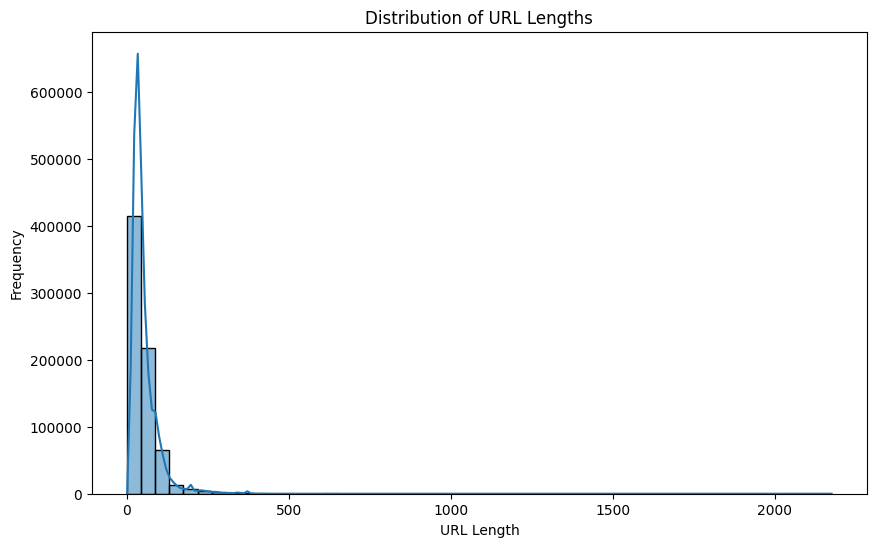

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(augmented_data['url_length'], bins=50, kde=True)
plt.title('Distribution of URL Lengths')
plt.xlabel('URL Length')
plt.ylabel('Frequency')
plt.show()

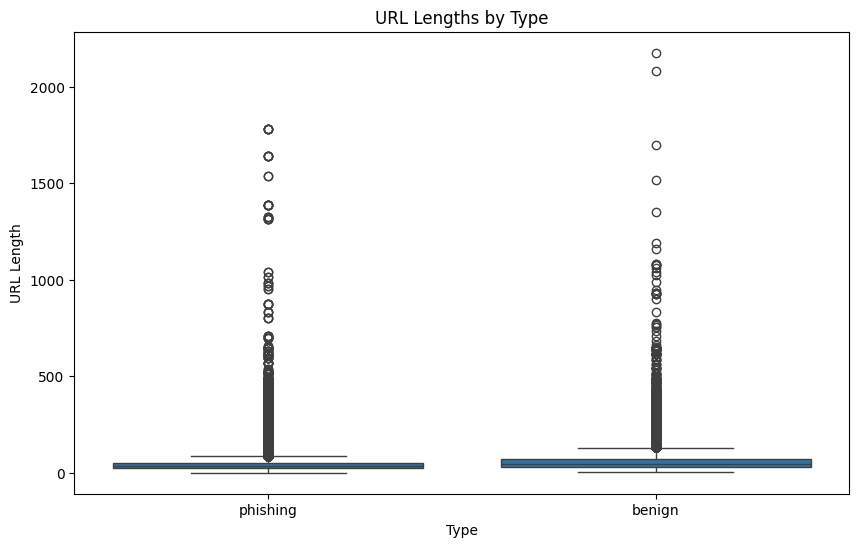

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='url_length', data=augmented_data)
plt.title('URL Lengths by Type')
plt.xlabel('Type')
plt.ylabel('URL Length')
plt.show()

In [17]:
#TLD Analysis usually helps in identifying common patterns in phishing URLs
augmented_data['tld'] = augmented_data['url'].apply(lambda x: x.split('.')[-1].split('/')[0])

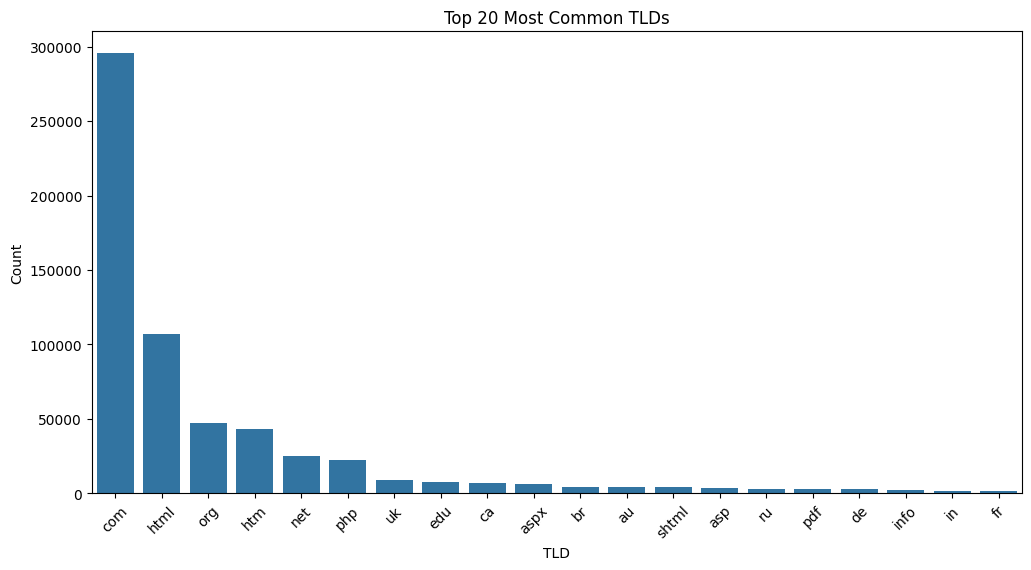

In [18]:
plt.figure(figsize=(12, 6))
top_tlds = augmented_data['tld'].value_counts().head(20)
sns.barplot(x=top_tlds.index, y=top_tlds.values)
plt.title('Top 20 Most Common TLDs')
plt.xlabel('TLD')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [19]:
# TLD distribution for 'phishing' vs 'benign'
tld_counts = augmented_data.groupby('type')['tld'].value_counts().unstack().fillna(0)
tld_counts = tld_counts[top_tlds.index]

<Figure size 1200x600 with 0 Axes>

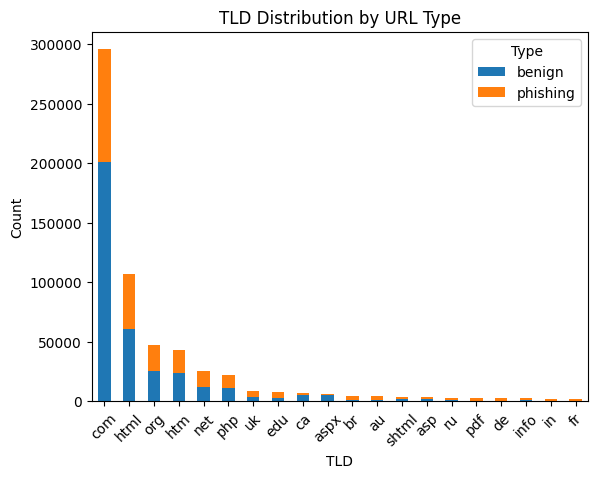

In [20]:
plt.figure(figsize=(12, 6))
tld_counts.T.plot(kind='bar', stacked=True)
plt.title('TLD Distribution by URL Type')
plt.xlabel('TLD')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Type')
plt.show()

In [21]:
#Checking for special characters or patterns in the URLs
import string

def count_special_chars(url):
    return sum([1 for char in url if char in string.punctuation])

augmented_data['special_char_count'] = augmented_data['url'].apply(count_special_chars)
print(augmented_data['special_char_count'].describe())

count    727775.000000
mean          7.733073
std           7.231266
min           0.000000
25%           4.000000
50%           6.000000
75%           9.000000
max         372.000000
Name: special_char_count, dtype: float64


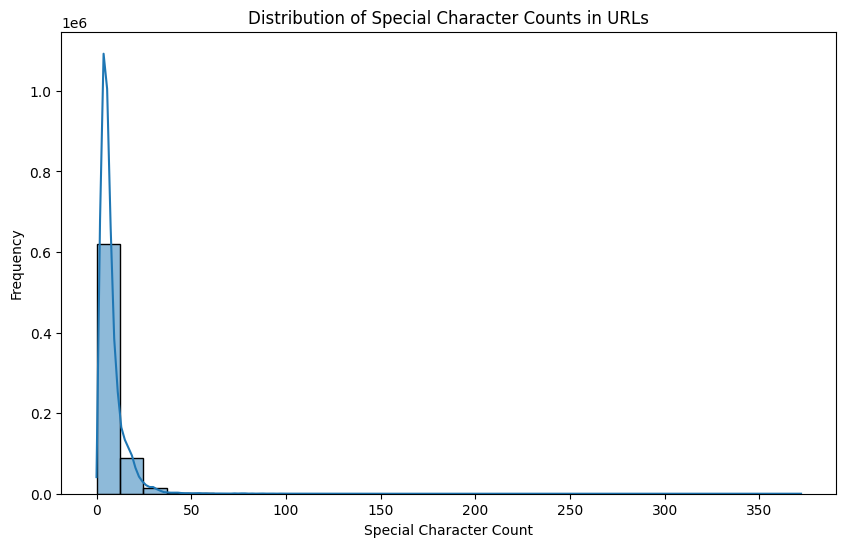

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(augmented_data['special_char_count'], bins=30, kde=True)
plt.title('Distribution of Special Character Counts in URLs')
plt.xlabel('Special Character Count')
plt.ylabel('Frequency')
plt.show()

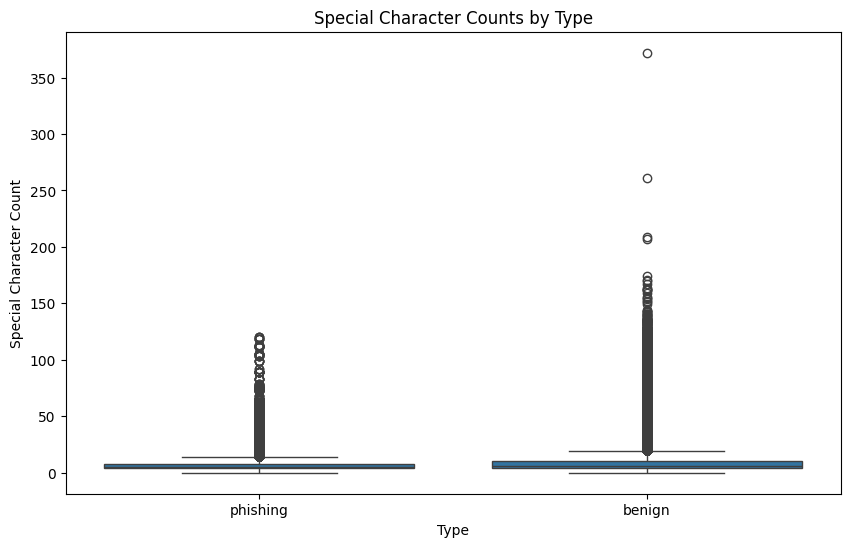

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='special_char_count', data=augmented_data)
plt.title('Special Character Counts by Type')
plt.xlabel('Type')
plt.ylabel('Special Character Count')
plt.show()

In [24]:
#Words present in the URLs can provide insights into common phishing tactics

from collections import Counter
from wordcloud import WordCloud
import re

def extract_words(url):
    return [word for word in re.split(r'\W+', url) if word]

augmented_data['url_words'] = augmented_data['url'].apply(extract_words)

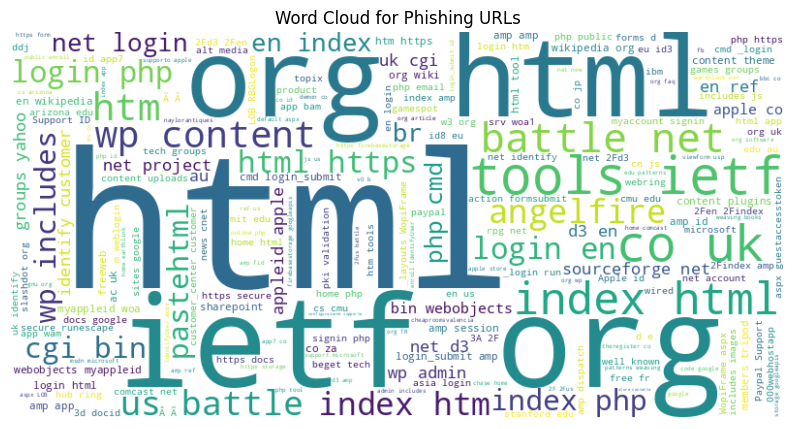

In [ ]:
phishing_words = augmented_data[augmented_data['type'] == 'phishing']['url_words'].sum()
phishing_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(phishing_words))

plt.figure(figsize=(10, 6))
plt.imshow(phishing_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Phishing URLs')
plt.show()

In [ ]:
# This word cloud is for the 'benign' URLs
benign_words = augmented_data[augmented_data['type'] == 0]['url_words'].sum()
benign_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(benign_words))

plt.figure(figsize=(10, 6))
plt.imshow(benign_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Benign URLs')
plt.show()

In [25]:
print(augmented_data.head())

                                                 url      type  url_length  \
0                        www.exontrol.com/extree.jsp  phishing          27   
1  hiplyrics.com/t/the-bilz-and-kashif-single-lyr...    benign          54   
2        www.pennine.demon.co.uk/family/armbasic.htm  phishing          43   
3  https://hoysalacreations.com/wp-content/plugin...  phishing          89   
4  groups.csail.mit.edu/mac/projects/scheme/rrrs-...  phishing          58   

    tld  special_char_count                                          url_words  
0   jsp                   4                  [www, exontrol, com, extree, jsp]  
1  html                   9  [hiplyrics, com, t, the, bilz, and, kashif, si...  
2   htm                   7  [www, pennine, demon, co, uk, family, armbasic...  
3   com                  14  [https, hoysalacreations, com, wp, content, pl...  
4  html                   9  [groups, csail, mit, edu, mac, projects, schem...  


In [26]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
augmented_data["type"] = lb_make.fit_transform(augmented_data["type"])
augmented_data["type"].value_counts()

type
0    428103
1    299672
Name: count, dtype: int64

In [27]:
from sklearn.model_selection import train_test_split

X = augmented_data.drop("type", axis=1)
y = augmented_data["type"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (509442, 5) (509442,)
Validation set size: (109166, 5) (109166,)
Test set size: (109167, 5) (109167,)


#Bi-LSTM

***Pre-Processing***

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [29]:
X = augmented_data['url_words'].values
y = augmented_data['type'].values

word_index = {}
index = 1
for sequence in X:
    for word in sequence:
        if word not in word_index:
            word_index[word] = index
            index += 1

X_indices = [[word_index[word] for word in sequence] for sequence in X]
max_sequence_length = 100
X_padded = pad_sequences(X_indices, maxlen=max_sequence_length, padding='post')
y_categorical = tf.keras.utils.to_categorical(y, num_classes=2)

from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [30]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=max_sequence_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

history = model.fit(X_train, y_train, epochs=5, batch_size=128, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

Epoch 1/5
3981/3981 [==============================] - 10726s 3s/step - loss: 0.1233 - accuracy: 0.9511 - val_loss: 0.0544 - val_accuracy: 0.9820 - lr: 0.0010
Epoch 2/5
3981/3981 [==============================] - 10665s 3s/step - loss: 0.0103 - accuracy: 0.9970 - val_loss: 0.0557 - val_accuracy: 0.9838 - lr: 0.0010
Epoch 3/5
3981/3981 [==============================] - 10663s 3s/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0790 - val_accuracy: 0.9854 - lr: 2.0000e-04


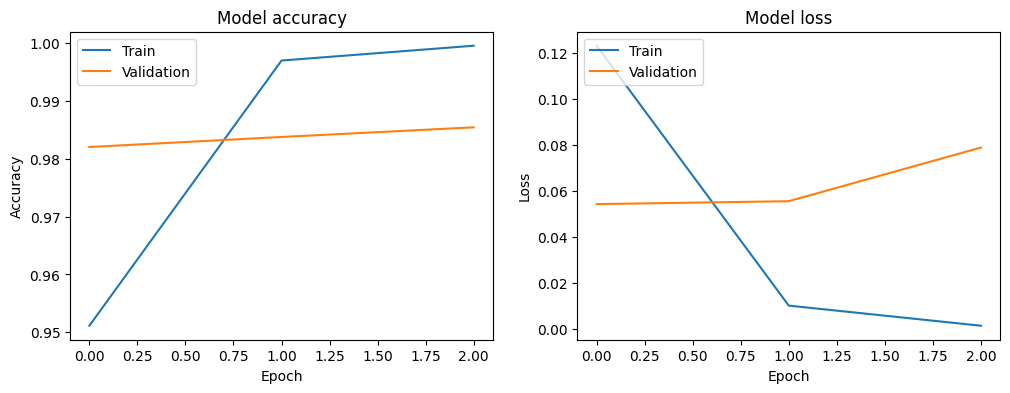

In [33]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_training_history(history)

In [37]:
import numpy as np

def preprocess_url(url):

    url_words = url.split('/')
    url_indices = [word_index.get(word, 0) for word in url_words]
    url_padded = pad_sequences([url_indices], maxlen=max_sequence_length, padding='post')

    return url_padded

In [38]:
def predict_url(url):

    preprocessed_url = preprocess_url(url)
    prediction = model.predict(preprocessed_url)
    predicted_class = np.argmax(prediction, axis=1)[0]

    return predicted_class

In [39]:
def get_label(predicted_class):
    if predicted_class == 0:
        return "benign"
    elif predicted_class == 1:
        return "phishing"

test_url = "mp3raid.com/music/krizz_kaliko.html"
predicted_class = predict_url(test_url)
predicted_label = get_label(predicted_class)

print(f"The URL '{test_url}' is predicted to be {predicted_label}.")

1/1 [==============================] - 3s 3s/step
The URL 'mp3raid.com/music/krizz_kaliko.html' is predicted to be benign.
